In [37]:
!pip install -r requirements.txt

<h1>Inizializzazione</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

from sklearn.metrics import accuracy_score

Inizializzazione dei dataset di train e test sulla base dei file "train.csv" e "test.csv" preparati tramite l'apposito notebook e caricamento del CSV da utilizzare come tabella di lookup per integrare le informazioni all'interno dei dataset.

In [2]:
train_set_original=pd.read_csv("train.csv")
test_set_original=pd.read_csv("test.csv")

poke_stats_dataset = pd.read_csv('pokemon.csv')

Definizione di una funzione per eliminare colonne da entrambi i dataframe.

In [3]:
def drop_columns(datasets: list, columns: list):
    for dataset in datasets:
        for column in columns:
            dataset.drop(columns=[f'{column}_fst', f'{column}_snd'], inplace = True, axis = 1)

Integrazione dei dataset di train e test con la tabella di lookup ed eliminazione dei parametri superflui (#_fst, #_snd). Infatti l'operazione di merge ha prodotto inevitabilmente della ridondanza. I restanti valori duplicati (differenziabili attraverso i suffissi "_fst" e "_snd") saranno necessari per aggiungere delle feature di comparazione tra statistiche, come spiegato successivamente.

In [4]:
train_set = train_set_original.merge(poke_stats_dataset, left_on='First_pokemon', right_on='#')
train_set = train_set.merge(poke_stats_dataset, left_on='Second_pokemon', right_on='#', suffixes=('_fst', '_snd'))

test_set = test_set_original.merge(poke_stats_dataset, left_on='First_pokemon', right_on='#')
test_set = test_set.merge(poke_stats_dataset, left_on='Second_pokemon', right_on='#', suffixes=('_fst', '_snd'))

drop_columns([train_set, test_set], ['#'])

In [5]:
train_set.head()

,Winner,First_pokemon,Second_pokemon,Name_fst,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,...,Type 1_snd,Type 2_snd,HP_snd,Attack_snd,Defense_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd
0,405,405,585,Relicanth,Water,Rock,100,90,130,45,...,Rock,NaN,70,105,105,50,40,20,5,False
1,667,667,585,Elgyem,Psychic,NaN,55,55,55,85,...,Rock,NaN,70,105,105,50,40,20,5,False
2,422,422,585,Kyogre,Water,NaN,100,100,90,150,...,Rock,NaN,70,105,105,50,40,20,5,False
3,409,409,585,Salamence,Dragon,Flying,95,135,80,110,...,Rock,NaN,70,105,105,50,40,20,5,False
4,585,671,585,Chandelure,Ghost,Fire,60,55,90,145,...,Rock,NaN,70,105,105,50,40,20,5,False


<h1>Analisi del dataset e preprocessing</h1>

Ispeziono il dataset di train così ottenuto.

In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 0 to 31999
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Winner          32000 non-null  int64 
 1   First_pokemon   32000 non-null  int64 
 2   Second_pokemon  32000 non-null  int64 
 3   Name_fst        31961 non-null  object
 4   Type 1_fst      32000 non-null  object
 5   Type 2_fst      16578 non-null  object
 6   HP_fst          32000 non-null  int64 
 7   Attack_fst      32000 non-null  int64 
 8   Defense_fst     32000 non-null  int64 
 9   Sp. Atk_fst     32000 non-null  int64 
 10  Sp. Def_fst     32000 non-null  int64 
 11  Speed_fst       32000 non-null  int64 
 12  Generation_fst  32000 non-null  int64 
 13  Legendary_fst   32000 non-null  bool  
 14  Name_snd        31974 non-null  object
 15  Type 1_snd      32000 non-null  object
 16  Type 2_snd      16670 non-null  object
 17  HP_snd          32000 non-null  int64 
 18  Attack

Si osserva che i campi "Name_fst", "Name_snd", "Type 2_fst" e "Type 2_snd" possiedono dei valori nulli.

Ad intuito:
- Considerato il contesto di battaglie tra pokémon, le feature relative al nome del pokémon non hanno rilevanza.
- Il "tipo" del pokémon sembra invece poter essere una feature rilevante ai fini della classificazione.

Date le considerazioni sopra effettuate, rimuovo le prime due feature, mentre sostituisco le seconde due con il loro rispettivo "Type 1", in modo tale da cercare di simulare la presenza di un secondo tipo.

Possibili soluzioni alternative, come l'aggiunta di un tipo "fantoccio" oppure eliminare completamente la colonna relativa al secondo tipo sono state scartate, in quanto la prima avrebbe potuto introdurre troppo rumore e la seconda avrebbe potuto potenzialmente eliminare delle informazioni utili alla classificazione.

In [7]:
drop_columns([train_set, test_set], ['Name'])

In [8]:
# sostituisce eventuali valori nulli del secondo tipo con quelli del primo
train_set['Type 2_fst'] = train_set.apply(lambda x: x['Type 1_fst'] if pd.isnull(x['Type 2_fst']) else x['Type 2_fst'], axis = 1)
train_set['Type 2_snd'] = train_set.apply(lambda x: x['Type 1_snd'] if pd.isnull(x['Type 2_snd']) else x['Type 2_snd'], axis = 1)

test_set['Type 2_fst'] = train_set.apply(lambda x: x['Type 1_fst'] if pd.isnull(x['Type 2_fst']) else x['Type 2_fst'], axis = 1)
test_set['Type 2_snd'] = train_set.apply(lambda x: x['Type 1_snd'] if pd.isnull(x['Type 2_snd']) else x['Type 2_snd'], axis = 1)

Imposto il problema come un problema di classificazione binaria, dove la label da prevedere è "Winner". Il classificatore dovrà rispondere alla domanda: "Quale dei due pokémon vincerà lo scontro?" 0 se è il primo, 1 altrimenti. Nella pratica, la label avrà valore 0 quando a vincere è il primo pokémon e 1 quando a vincere sarà il secondo.

In [9]:
def calc_binary_label (label_id, first_id, second_id):
    if (label_id == first_id):
        return 0
    else:
        return 1

train_set['Winner'] = train_set.apply(lambda x: calc_binary_label(x['Winner'], x['First_pokemon'], x['Second_pokemon']), axis = 1)
test_set['Winner'] = test_set.apply(lambda x: calc_binary_label(x['Winner'], x['First_pokemon'], x['Second_pokemon']), axis = 1)

In [10]:
train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Type 1_snd,Type 2_snd,HP_snd,Attack_snd,Defense_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd
0,0,405,585,Water,Rock,100,90,130,45,65,...,Rock,Rock,70,105,105,50,40,20,5,False
1,0,667,585,Psychic,Psychic,55,55,55,85,55,...,Rock,Rock,70,105,105,50,40,20,5,False
2,0,422,585,Water,Water,100,100,90,150,140,...,Rock,Rock,70,105,105,50,40,20,5,False
3,0,409,585,Dragon,Flying,95,135,80,110,80,...,Rock,Rock,70,105,105,50,40,20,5,False
4,1,671,585,Ghost,Fire,60,55,90,145,90,...,Rock,Rock,70,105,105,50,40,20,5,False


Effettuo un label encoding sulle feature sotto elencate. Operazione necessaria al fine di poter utilizzare i dati per la costruzione del decision tree classifier. 

In [11]:
encoded_features = ['Type 1_fst', 'Type 2_fst','Legendary_fst', 'Type 1_snd', 'Type 2_snd', 'Legendary_snd']
encoder = preprocessing.LabelEncoder()

for e in encoded_features:
    train_set[e] = encoder.fit_transform(train_set[e])
    test_set[e] = encoder.fit_transform(test_set[e])

train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Type 1_snd,Type 2_snd,HP_snd,Attack_snd,Defense_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd
0,0,405,585,17,15,100,90,130,45,65,...,15,15,70,105,105,50,40,20,5,0
1,0,667,585,14,14,55,55,55,85,55,...,15,15,70,105,105,50,40,20,5,0
2,0,422,585,17,17,100,100,90,150,140,...,15,15,70,105,105,50,40,20,5,0
3,0,409,585,2,7,95,135,80,110,80,...,15,15,70,105,105,50,40,20,5,0
4,1,671,585,8,6,60,55,90,145,90,...,15,15,70,105,105,50,40,20,5,0


In [12]:
train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Type 1_snd,Type 2_snd,HP_snd,Attack_snd,Defense_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd
0,0,405,585,17,15,100,90,130,45,65,...,15,15,70,105,105,50,40,20,5,0
1,0,667,585,14,14,55,55,55,85,55,...,15,15,70,105,105,50,40,20,5,0
2,0,422,585,17,17,100,100,90,150,140,...,15,15,70,105,105,50,40,20,5,0
3,0,409,585,2,7,95,135,80,110,80,...,15,15,70,105,105,50,40,20,5,0
4,1,671,585,8,6,60,55,90,145,90,...,15,15,70,105,105,50,40,20,5,0


Ad intuito, modello delle feature basate sulla differenza tra le statistiche dei pokémon duellanti, in modo da poter studiare meglio il dominio ed eventualmente arricchire ulteriolmente il dataset da portare in fase di addestramento.

In [13]:
diff_features = ['HP_diff', 'Attack_diff', 'Defense_diff', 'Sp. Atk_diff,', 'Sp. Def_diff', 'Speed_diff']

for dataset in [train_set, test_set]:
    for f in diff_features:
        current_f = f.split('_')[0]
        dataset[f] = dataset[current_f + '_fst'] - dataset[current_f + '_snd']

In [14]:
train_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd,HP_diff,Attack_diff,Defense_diff,"Sp. Atk_diff,",Sp. Def_diff,Speed_diff
0,0,405,585,17,15,100,90,130,45,65,...,40,20,5,0,30,-15,25,-5,25,35
1,0,667,585,14,14,55,55,55,85,55,...,40,20,5,0,-15,-50,-50,35,15,10
2,0,422,585,17,17,100,100,90,150,140,...,40,20,5,0,30,-5,-15,100,100,70
3,0,409,585,2,7,95,135,80,110,80,...,40,20,5,0,25,30,-25,60,40,80
4,1,671,585,8,6,60,55,90,145,90,...,40,20,5,0,-10,-50,-15,95,50,60


In [15]:
test_set.head()

,Winner,First_pokemon,Second_pokemon,Type 1_fst,Type 2_fst,HP_fst,Attack_fst,Defense_fst,Sp. Atk_fst,Sp. Def_fst,...,Sp. Def_snd,Speed_snd,Generation_snd,Legendary_snd,HP_diff,Attack_diff,Defense_diff,"Sp. Atk_diff,",Sp. Def_diff,Speed_diff
0,0,513,724,1,15,70,120,65,45,85,...,100,104,6,0,-5,51,-7,-69,-15,21
1,1,676,724,11,14,95,110,80,70,80,...,100,104,6,0,20,41,8,-44,-20,-54
2,1,178,724,12,17,60,30,30,36,56,...,100,104,6,0,-15,-39,-42,-78,-44,-54
3,1,444,724,12,7,85,120,70,50,60,...,100,104,6,0,10,51,-2,-64,-40,-4
4,1,505,724,13,6,83,106,65,86,65,...,100,104,6,0,8,37,-7,-28,-35,-19


<h1>Feature Selection</h1>

Costruisco la matrice di correlazione, che permette di osservare la connessione inter-feature, in modo tale da riuscire a discernere la rilevanza delle caratteristiche in relazione alla label da utilizzare per la classificazione, "Winner", ed effettuare una selezione (o in questo caso scrematura).

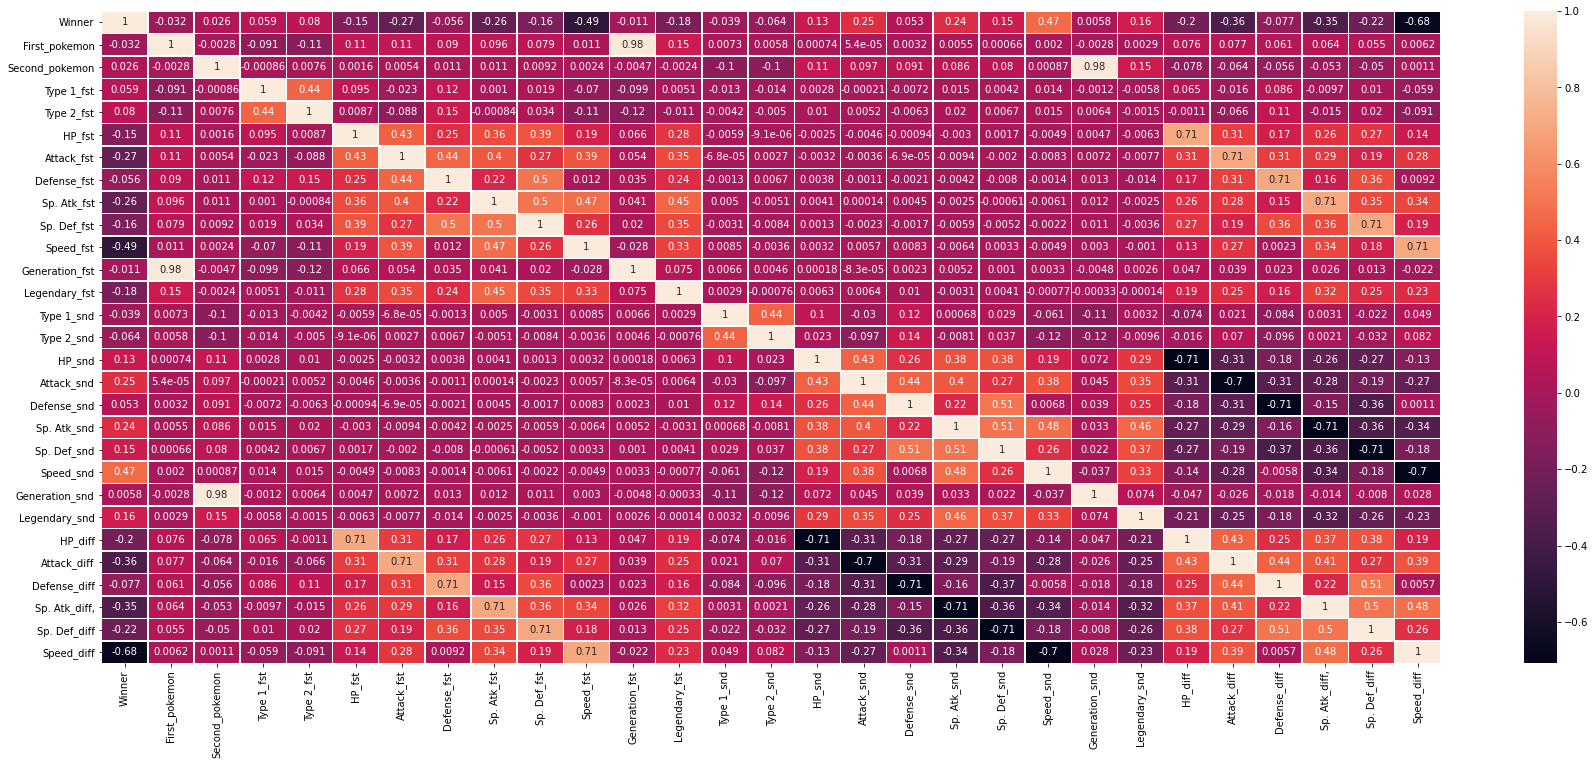

In [16]:
plt.figure(figsize=(30, 12))
corr_matrix = train_set.corr()
sns.heatmap(corr_matrix, annot = True, linewidth = 0.5)
plt.show()

Di tutta la matrice, la colonna di particolare interesse è quella relativa alla label di classificazione "Winner" (Come già preannunciato).
Come si può notare dal grafico, le feature basate su differenze di statistiche dei pokémon associati a ciascun campione hanno mediamente una discreta influenza sull'esito della battaglia, quindi si può confermare che l'idea di aggiungerle alla modellazione sia plausibile.

Da notare come la "Speed_diff" abbia correlazione particolarmente elevata con la label, suggerendo una notevole importanza della statistica al fine della determinazione dell'esito dello scontro, mentre "Def_diff" abbia molta poca rilevanza.

Scelgo come soglia di coefficiente di correlazione 0.1, considerando poco significative tutte le feature avente valore assoluto del suddetto coefficiente inferiore alla soglia.
Elimino dal dataset tali feature (First_pokemon, Second_pokemon, Type 1_fst, Type 2_fst, Defense_fst, Generation_fst, Type 1_snd, Type 2_snd, Defense_snd, Generation_snd, Defense_diff).

In [17]:
def drop_columns_generic(datasets: list, columns: list):
    for dataset in datasets:
        for column in columns:
            dataset.drop(columns=[f'{column}'], inplace = True, axis = 1)

In [18]:
drop_columns_generic([train_set, test_set], ['First_pokemon', 'Second_pokemon', 'Defense_diff'])
drop_columns([train_set, test_set], ['Type 1', 'Type 2', 'Defense', 'Generation', 'Legendary'])

Di conseguenza, ecco la heatmap corretta della matrice di correlazione, una volta effettuata una prima scrematura.

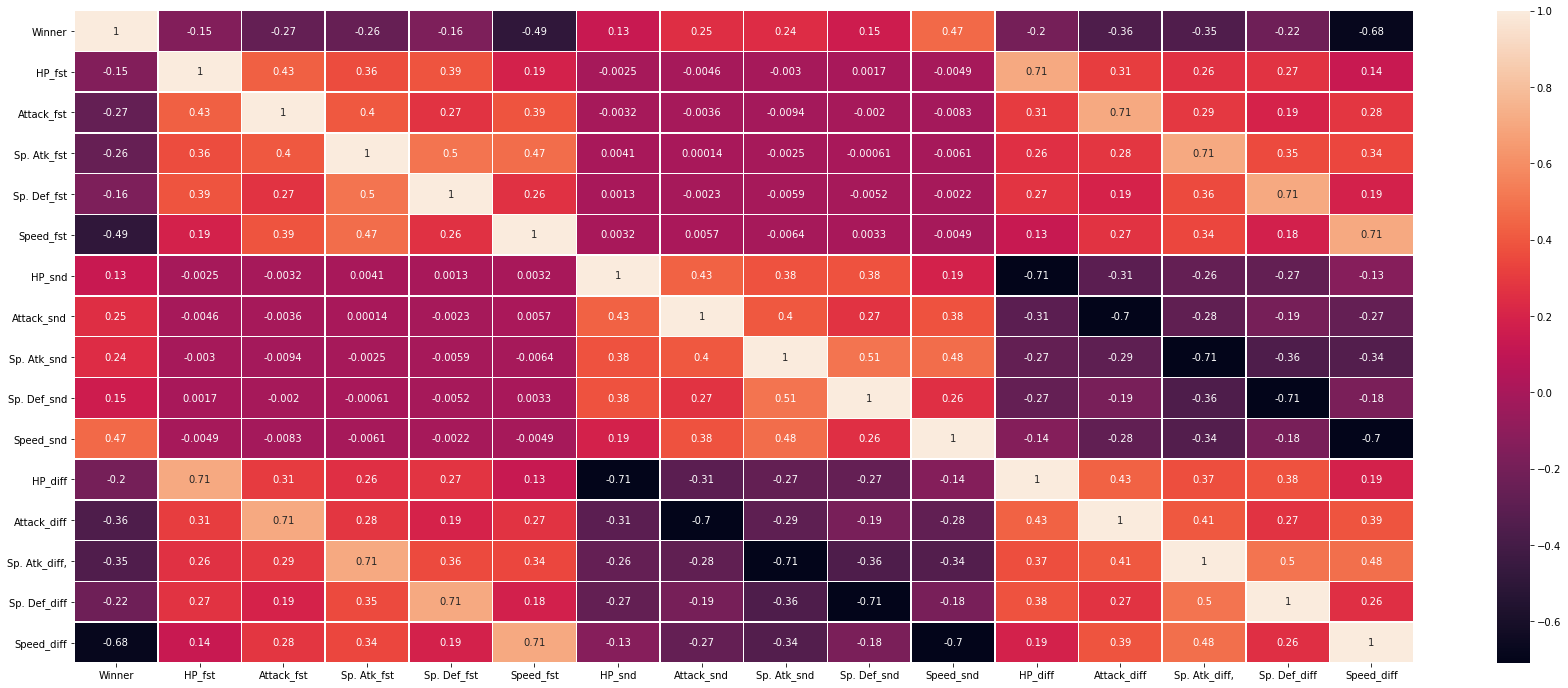

In [19]:
plt.figure(figsize=(30, 12))
corr_matrix = train_set.corr()
sns.heatmap(corr_matrix, annot = True, linewidth = 0.5)
plt.show()

In [20]:
train_set.head()

,Winner,HP_fst,Attack_fst,Sp. Atk_fst,Sp. Def_fst,Speed_fst,HP_snd,Attack_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,HP_diff,Attack_diff,"Sp. Atk_diff,",Sp. Def_diff,Speed_diff
0,0,100,90,45,65,55,70,105,50,40,20,30,-15,-5,25,35
1,0,55,55,85,55,30,70,105,50,40,20,-15,-50,35,15,10
2,0,100,100,150,140,90,70,105,50,40,20,30,-5,100,100,70
3,0,95,135,110,80,100,70,105,50,40,20,25,30,60,40,80
4,1,60,55,145,90,80,70,105,50,40,20,-10,-50,95,50,60


In [21]:
test_set.head()

,Winner,HP_fst,Attack_fst,Sp. Atk_fst,Sp. Def_fst,Speed_fst,HP_snd,Attack_snd,Sp. Atk_snd,Sp. Def_snd,Speed_snd,HP_diff,Attack_diff,"Sp. Atk_diff,",Sp. Def_diff,Speed_diff
0,0,70,120,45,85,125,75,69,114,100,104,-5,51,-69,-15,21
1,1,95,110,70,80,50,75,69,114,100,104,20,41,-44,-20,-54
2,1,60,30,36,56,50,75,69,114,100,104,-15,-39,-78,-44,-54
3,1,85,120,50,60,100,75,69,114,100,104,10,51,-64,-40,-4
4,1,83,106,86,65,85,75,69,114,100,104,8,37,-28,-35,-19


<h1>Training e Testing</h1>

Preparo i dati per l'addestramento, ovvero estraggo la label target ("Winner") dai dataset, in modo da poter applicare algoritmi di apprendimento supervisionato, per poter realizzare un modello che sia in grado di determinare il valore eliminato a monte con la massima accuratezza possibile.
Normalizzo i dataset tramite l2-norm per ridurre il range dei valori delle feature.

In [22]:
X_train = train_set.copy()
y_train = X_train.pop('Winner')
X_train = preprocessing.normalize(X_train, norm='l2')

X_test = test_set.copy()
y_test = X_test.pop('Winner')
X_test = preprocessing.normalize(X_test, norm='l2')

Come tipologia di classificatore da utilizzare scelgo un *decision tree classifier*.

Alleno il modello 10 volte (in modo da poter osservare quanto un fattore randomico possa influire sull'allenamento) e calcolo l'accuracy sulla predict degli elementi del test_set. 

In [23]:
dtree = tree.DecisionTreeClassifier()
dtree_results = []

for i in range(10):
    dtree.fit(X_train, y_train)

    y_train_pred=dtree.predict(X_train)
    y_test_pred=dtree.predict(X_test)

    train_accuracy, test_accuracy = round(accuracy_score(y_train, y_train_pred)*100, 2), round(accuracy_score(y_test, y_test_pred)*100, 2)
    dtree_results.append(test_accuracy)

    print(f"Decision Tree Classifier")
    print(f"Training Accuracy = {train_accuracy}%")
    print(f"Test Accuracy = {test_accuracy}%\n")

best_result = max(dtree_results)
worst_result = min(dtree_results)
print(f'Results over 10 iterations = {dtree_results}')
print(f'Best result = {best_result}%')
print(f'Worst result = {worst_result}%')


Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 92.14%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 92.2%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 92.2%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.95%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.88%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 91.85%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 92.22%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 92.2%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 92.09%

Decision Tree Classifier
Training Accuracy = 100.0%
Test Accuracy = 92.09%

Results over 10 iterations = [92.14, 92.2, 92.2, 91.95, 91.88, 91.85, 92.22, 92.2, 92.09, 92.09]
Best result = 92.22%
Worst result = 91.85%


Rappresentazione testuale del decision tree. A rischio e pericolo del lettore, anche uno snippet di codice per poter visualizzare e stampare l'albero.

In [24]:
text_representation = tree.export_text(dtree)
print(text_representation)

2 <= 0.12
|   |   |   |   |   |   |   |   |   |--- feature_13 <= 0.27
|   |   |   |   |   |   |   |   |   |   |--- feature_14 <= 0.18
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_14 >  0.18
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |--- feature_13 >  0.27
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_12 >  0.12
|   |   |   |   |   |   |   |   |   |--- feature_8 <= 0.34
|   |   |   |   |   |   |   |   |   |   |--- feature_12 <= 0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_12 >  0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- feature_8 >  0.34
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_11

In [25]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dtree,
#                    filled=True)
# fig.savefig("decision_tree.png")

Di seguito, la matrice di confusione dell'ultimo modello allenato, che ci permette di quantificare quanti errori di tipo 1 e 2 il classificatore abbia commesso.

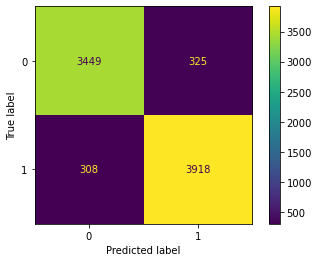

In [26]:
plot_confusion_matrix(dtree, X_test, y_test, values_format='n')
plt.show() 

### Drop di nuove feature

Provo ad alzare la soglia di coefficiente di correlazione a 0.2. Questo si traduce nell'eliminazione di altre 4 feature: "HP_fst", "HP_snd", "Sp. Def_fst" e "Sp. Def_snd".
Effettuo esattamente gli stessi passaggi di prima, con i nuovi train e test set.


In [27]:
drop_columns([train_set, test_set], ['HP', 'Sp. Def'])

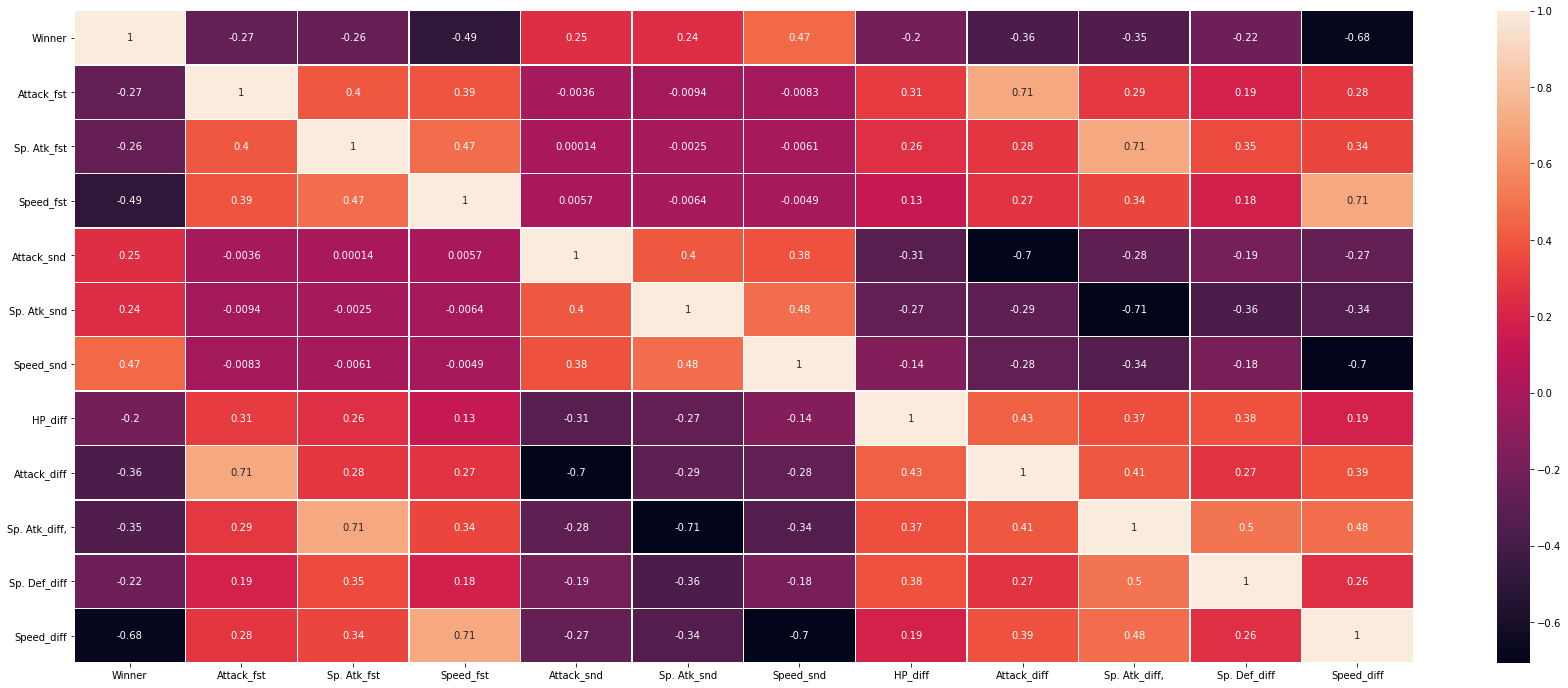

In [28]:
plt.figure(figsize=(30, 12))
corr_matrix = train_set.corr()
sns.heatmap(corr_matrix, annot = True, linewidth = 0.5)
plt.show()

In [29]:
dtree_less_f = tree.DecisionTreeClassifier()
dtree_results_less_f = []

for i in range(10):
    dtree_less_f.fit(X_train, y_train)

    y_train_pred=dtree_less_f.predict(X_train)
    y_test_pred=dtree_less_f.predict(X_test)
    dtree_results_less_f.append(test_accuracy)

    train_accuracy, test_accuracy = round(accuracy_score(y_train, y_train_pred)*100, 2), round(accuracy_score(y_test, y_test_pred)*100, 2)

    print(f"Decision Tree Classifier with less features")
    print(f"Training Accuracy = {train_accuracy}%")
    print(f"Test Accuracy = {test_accuracy}%\n")
best_result_less_f = max(dtree_results_less_f)
worst_result_less_f = min(dtree_results_less_f)
print(f'Results over 10 iterations = {dtree_results_less_f}')
print(f'Best result = {best_result_less_f}%')
print(f'Worst result = {worst_result_less_f}%')

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 92.22%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.98%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 92.05%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 92.09%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.9%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 91.86%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 92.01%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 92.0%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 92.02%

Decision Tree Classifier with less features
Training Accuracy = 100.0%
Test Accuracy = 92.09%

Results over 10 iterations = [92.09, 92.22, 91.98, 9

In [30]:
text_representation = tree.export_text(dtree_less_f)
print(text_representation)

<= 0.12
|   |   |   |   |   |   |   |   |   |--- feature_13 <= 0.27
|   |   |   |   |   |   |   |   |   |   |--- feature_14 <= 0.18
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- feature_14 >  0.18
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |--- feature_13 >  0.27
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_12 >  0.12
|   |   |   |   |   |   |   |   |   |--- feature_8 <= 0.34
|   |   |   |   |   |   |   |   |   |   |--- feature_12 <= 0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_12 >  0.13
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- feature_8 >  0.34
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_11 >

In [31]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dtree_less_f,
#                    filled=True)
# fig.savefig("decision_tree.png")

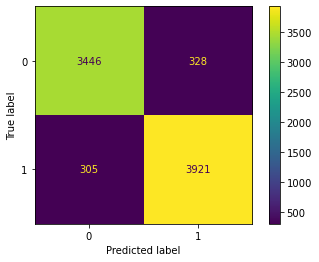

In [32]:
plot_confusion_matrix(dtree_less_f, X_test, y_test, values_format='n')
plt.show() 

In [33]:
results = pd.DataFrame({
    'Model': ['Decision Tree(15_features)', 'Decision Tree(11_features)'],
    'Best Result': [best_result, best_result_less_f],
    'Worst Result': [worst_result, worst_result_less_f]
})
results.sort_values(by='Best Result', ascending=False)

,Model,Best Result,Worst Result
0,Decision Tree(15_features),92.22,91.85
1,Decision Tree(11_features),92.22,91.86


Come si può osservare dalla tabella sopra riportata, la scelta di escludere anche le feature relative ad HP e Sp. Def sembra essersi rivelata corretta al fine di risolvere il problema della determinazione di un sottoinsieme ottimale, poiché la differenza tra le metriche dei due modelli è dell'ordine di pochi centesimi percentuali. Si evince quindi che  contributo delle quattro feature rimosse è considerabile irrisorio al fine della classificazione tramite decision tree (non aggiungono informazioni rilevanti) e si può scegliere come classificatore il "Decision Tree(11_features)".

Aumentare ulteriormente la soglia di correlazione minima non produce risultati migliori. Potrebbe essere interessante analizzare esplicitamente le varie feature e cercare di scoprire qualche pattern non determinabile attraverso il semplice studio dei coefficienti di correlazione.

Normalizzare i valori tramite l2-norm ha portato un miglioramento di circa 0.3% di accuracy rispetto ai modelli allenati senza normalizzazione, affermando tale processo come necessario al fine di ottenere prestazioni migliori.
